## MUSIC GENRE CLASSIFICATION WITH KERAS

In [35]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import librosa, librosa.display
import math
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## PREPROCESSING AUDIO

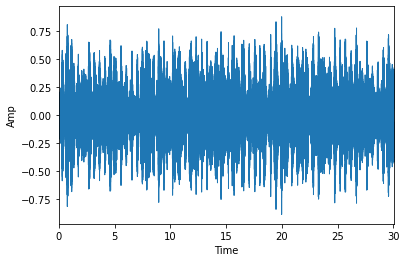

In [36]:
file = './genres/blues/blues.00000.wav'

sig, sr = librosa.load(file, sr=22050)
librosa.display.waveplot(sig, sr = sr)
plt.xlabel("Time")
plt.ylabel("Amp")
plt.show()

Text(0, 0.5, 'Mag')

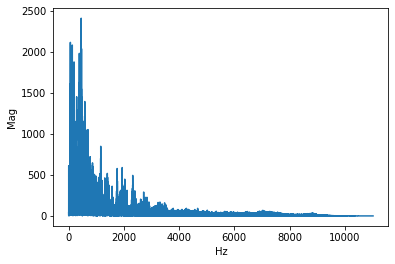

In [37]:
fft = np.fft.fft(sig)
mag = np.abs(fft)
freq = np.linspace(0, sr, len(mag))
hfreq = freq[:int(len(freq)/2)]
hmag = mag[:int(len(mag)/2)]
plt.plot(hfreq,hmag)
plt.xlabel("Hz")
plt.ylabel("Mag")

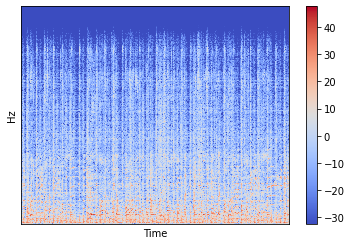

In [38]:
n_fft = 2048
hop_size = 512

stft = librosa.core.stft(sig, hop_length = hop_size, n_fft = n_fft)
spec = np.abs(stft)
log_spec = librosa.amplitude_to_db(spec)
librosa.display.specshow(log_spec,sr = sr, hop_length = hop_size)
plt.xlabel("Time")
plt.ylabel("Hz")
plt.colorbar()
plt.show()

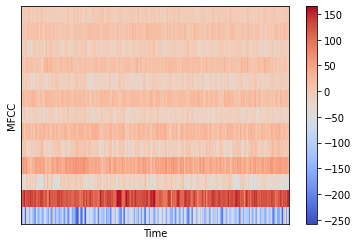

In [39]:
MFCCs = librosa.feature.mfcc(sig, n_fft = 2048, hop_length = hop_size, n_mfcc = 13)
librosa.display.specshow(MFCCs,sr = sr, hop_length = hop_size)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()



## PREPROCESSING MUSIC GENRE DATASET

In [41]:
DATASET_P = "genres" # using the genre dataset from http://marsyas.info/downloads/datasets.html
JSON_P = "data.json"
SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, n_segments=5):
    data = {
        "mapping": [],
        "mfcc"   : [],
        "label"  : []
    }
    
    num_samples_per_segment = int (SAMPLES_PER_TRACK / n_segments)
    expected_num_mfcc_vecs_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split("/")
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print("\n Processing {}".format(semantic_label))
            
            for f in filenames:
                file_path = os.path.join(dirpath, f) 
                sig, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                # process segment, extract mfcc, store data
                for s in range(n_segments):
                    start_s = num_samples_per_segment * s
                    end_s   = start_s + num_samples_per_segment
                    mfcc = librosa.feature.mfcc(sig[start_s:end_s], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    if len(mfcc) == expected_num_mfcc_vecs_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["label"].append(i-1) # first iteration is the dataset path, so we ignore it
                        # print("{}, segment:{}".format(file_path,s+1))
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        

In [42]:
save_mfcc(DATASET_P, JSON_P, n_segments=10)


 Processing pop

 Processing metal

 Processing disco

 Processing blues

 Processing reggae

 Processing classical

 Processing rock

 Processing hiphop

 Processing country

 Processing jazz


In [43]:
def load_data(dataset_p):
    with open(dataset_p, "r") as fp:
        data = json.load(fp)
    inputs = np.array(data["mfcc"])
    targets = np.array(data["label"])
    
    return inputs, targets

inputs, targets = load_data(JSON_P)

In [44]:

in_tr, in_test, t_tr, t_test = train_test_split(inputs, targets, test_size=0.3)

in_tr = in_tr[..., np.newaxis]
in_test = in_test[..., np.newaxis]
t_tr = t_tr[..., np.newaxis]
t_test=t_test[..., np.newaxis]
input_shape = (in_tr.shape[1],in_tr.shape[2],1)


In [45]:
def plot_hist(history):
    fig, axs = plt.subplots(2)
    #accuracy plot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    #error plot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()

## BUILD AND TRAIN THE NETWORK 1: CNN

In [46]:
input_layer = Input(input_shape)
x = Conv2D(32, (3,3))(input_layer)
x = Activation('relu')(x)
x = MaxPooling2D((3,3),strides=(2,2),padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3))(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3),strides=(2,2),padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (2,2))(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),strides=(2,2),padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(10)(x)
x = BatchNormalization()(x)
output_layer = Activation('softmax')(x)

model1 = Model(input_layer, output_layer)
opt = Adam(learning_rate=0.0001)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 130, 13, 1)]      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 activation_8 (Activation)   (None, 128, 11, 32)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 4, 32)         9248

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [47]:
model1.fit(in_tr, t_tr, validation_data=(in_test, t_test),epochs=50,batch_size=32,shuffle=True)

Epoch 1/50
219/219 [==============================] - 7s 26ms/step - loss: 2.6455 - accuracy: 0.2258 - val_loss: 2.2754 - val_accuracy: 0.3745
Epoch 2/50
219/219 [==============================] - 5s 25ms/step - loss: 2.2383 - accuracy: 0.3760 - val_loss: 2.0195 - val_accuracy: 0.4658
Epoch 3/50
219/219 [==============================] - 6s 29ms/step - loss: 2.1031 - accuracy: 0.4222 - val_loss: 1.9358 - val_accuracy: 0.5105
Epoch 4/50
219/219 [==============================] - 6s 29ms/step - loss: 2.0225 - accuracy: 0.4541 - val_loss: 1.8349 - val_accuracy: 0.5445
Epoch 5/50
219/219 [==============================] - 6s 29ms/step - loss: 1.9443 - accuracy: 0.4908 - val_loss: 1.7798 - val_accuracy: 0.5762
Epoch 6/50
219/219 [==============================] - 7s 31ms/step - loss: 1.8827 - accuracy: 0.5175 - val_loss: 1.7130 - val_accuracy: 0.5979
Epoch 7/50
219/219 [==============================] - 6s 29ms/step - loss: 1.8257 - accuracy: 0.5417 - val_loss: 1.6694 - val_accuracy: 0.6035

In [48]:
model1.evaluate(in_test, t_test, batch_size=32)

94/94 [==============================] - 1s 8ms/step - loss: 0.9694 - accuracy: 0.7679


[0.9693644642829895, 0.7679226398468018]

In [49]:
GENRES = np.array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])

preds = model1.predict(in_test)
preds_single = GENRES[np.argmax(preds, axis = 1)]
actual_single = GENRES[t_test]

In [50]:
indices = np.random.choice(range(len(in_test)), 10)
for i, idx in enumerate(indices):
    print("\npredicted: {}".format(preds_single[idx]))
    print("\n correct: {}".format(actual_single[idx]))


predicted: reggae

 correct: ['reggae']

predicted: reggae

 correct: ['reggae']

predicted: blues

 correct: ['blues']

predicted: disco

 correct: ['disco']

predicted: classical

 correct: ['classical']

predicted: metal

 correct: ['metal']

predicted: hiphop

 correct: ['pop']

predicted: metal

 correct: ['metal']

predicted: rock

 correct: ['rock']

predicted: metal

 correct: ['metal']


## NETWORK 2: LSTM-RNN

In [51]:
input_shape = (in_tr.shape[1],in_tr.shape[2])
input_layer = Input(input_shape)
x = LSTM(64, return_sequences=True)(input_layer)
x = LSTM(64)(x)
x = Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(10)(x)
x = BatchNormalization()(x)
output_layer = Activation('softmax')(x)

model2 = Model(input_layer, output_layer)
opt = Adam(lr=0.0001)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 130, 13)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_14 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 64)                0         
                                                           

In [52]:
in_tr, in_test, t_tr, t_test = train_test_split(inputs, targets, test_size =0.3)
in_tr.shape

(6997, 130, 13)

In [53]:
model2.fit(in_tr, t_tr, validation_data=(in_test, t_test),epochs=50,batch_size=32,shuffle=True)


Epoch 1/50
219/219 [==============================] - 15s 58ms/step - loss: 2.3937 - accuracy: 0.1999 - val_loss: 2.1509 - val_accuracy: 0.2641
Epoch 2/50
219/219 [==============================] - 12s 54ms/step - loss: 2.0419 - accuracy: 0.3054 - val_loss: 1.8823 - val_accuracy: 0.3811
Epoch 3/50
219/219 [==============================] - 12s 54ms/step - loss: 1.9066 - accuracy: 0.3567 - val_loss: 1.7488 - val_accuracy: 0.4141
Epoch 4/50
219/219 [==============================] - 12s 54ms/step - loss: 1.8226 - accuracy: 0.3842 - val_loss: 1.6851 - val_accuracy: 0.4351
Epoch 5/50
219/219 [==============================] - 12s 54ms/step - loss: 1.7521 - accuracy: 0.4215 - val_loss: 1.6317 - val_accuracy: 0.4575
Epoch 6/50
219/219 [==============================] - 12s 54ms/step - loss: 1.6892 - accuracy: 0.4518 - val_loss: 1.5927 - val_accuracy: 0.4725
Epoch 7/50
219/219 [==============================] - 12s 54ms/step - loss: 1.6415 - accuracy: 0.4683 - val_loss: 1.5535 - val_accuracy:

In [54]:
model2.evaluate(in_test, t_test, batch_size=32)

94/94 [==============================] - 1s 15ms/step - loss: 1.0583 - accuracy: 0.6852


[1.0582505464553833, 0.6852284073829651]

In [55]:
GENRES = np.array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])

preds = model2.predict(in_test)
preds_single = GENRES[np.argmax(preds, axis = 1)]
actual_single = GENRES[t_test]

indices = np.random.choice(range(len(in_test)), 10)

for i, idx in enumerate(indices):
    print("\npredicted: {}".format(preds_single[idx]))
    print("\n correct: {}".format(actual_single[idx]))


predicted: hiphop

 correct: metal

predicted: disco

 correct: metal

predicted: blues

 correct: blues

predicted: pop

 correct: pop

predicted: disco

 correct: disco

predicted: rock

 correct: rock

predicted: pop

 correct: disco

predicted: country

 correct: hiphop

predicted: pop

 correct: blues

predicted: rock

 correct: rock
